### Goal of this project
Given a bitcoin address along with some meta-data pertaining to that address,  
we are challenged to predict if that address has been used to receive ransoms in the past.

### Notebook Workflow:
 1. Setup Libraries
 2. Read The Data
 3. Data Overview
 4. Exploratory Data Analysis 
  - Checking for NaN
  - Droping any duplicates
  - Column Rename
  - Set The Classes (Labels)
  - Class Imbalance Struggle 
  - Feature Distribution
 5. Baseline 
 6. Feature Engineering
 7. Store The Data

# 

### 1.  Setup

Data manipulation libraries:

In [1]:
import pandas as pd
import numpy  as np

Visualization libraries:

In [2]:
import matplotlib.pyplot  as plt
import seaborn            as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

Pre-processing and modeling libraries:

In [3]:
from  scipy.stats              import boxcox 
from  tqdm.notebook            import tqdm
import datetime

In [47]:
from sklearn.preprocessing     import StandardScaler
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split
from sklearn.metrics           import confusion_matrix, precision_score, recall_score, f1_score

# 

### 2. Data-set

In [5]:
file_path = 'BitcoinHeistData.csv'

data = pd.read_csv(file_path)

# 

### 3.  Data Overview

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   address    object 
 1   year       int64  
 2   day        int64  
 3   length     int64  
 4   weight     float64
 5   count      int64  
 6   looped     int64  
 7   neighbors  int64  
 8   income     float64
 9   label      object 
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB


In [7]:
data.head(2)

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky


In [8]:
data.sample(2)

,address,year,day,length,weight,count,looped,neighbors,income,label
193843,1KgPRiETPJUytk8PhFFRDMNi1HJYXghct2,2011,163,140,1.164153e-10,24,0,2,31296321.0,white
1877930,1MpdXebLT2gzGZq42gAuUzj6UEbXBkNXqu,2016,22,0,5.000000e-01,1,0,1,40271860.0,white


In [9]:
data.tail(2)

,address,year,day,length,weight,count,looped,neighbors,income,label
2916695,15iPUJsRNZQZHmZZVwmQ63srsmughCXV4a,2018,330,0,0.500000,1,0,1,178042670.0,white
2916696,3LFFBxp15h9KSFtaw55np8eP5fv6kdK17e,2018,330,144,0.073972,6800,0,2,112350000.0,white


In [10]:
print('Data has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

Data has 2916697 rows and 10 columns


In [11]:
print('Data columns: \n{}'.format(list(data.columns)[:-1]))

Data columns: 
['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']


# 

### 4. Exploratory Data Analysis

#### 4.1 Checking for NaN

In [12]:
data.isnull().values.any()

False

# 

####  4.2  Droping any duplicates 

In [13]:
data = data.drop_duplicates()

In [14]:
data.shape

(2916697, 10)

# 

#### 4.3 Column Rename 

- The count column may confuse the computer with the count() function,
so lets rename it.

In [15]:
data.rename(columns={'count':'counted'},inplace=True)

# 

#### 4.4 Set The Classes (Labels)

- The positive class is any kind of "ransomware label" will takes '1' as value.  
The negative class is the "White label" will takes '0' as value. 

In [16]:
data['label'] = data['label'].apply(lambda x: 0 if x == 'white' else 1)

In [17]:
print('Number of white (non-ransomware) datapoints: {}\nNumber of ransomware datapoints: {}'\
      .format(data['label'].value_counts
              ()[0], 
              sum(data['label'].value_counts()[1:])
             ))

Number of white (non-ransomware) datapoints: 2875284
Number of ransomware datapoints: 41413


In [18]:
print('Percentage of data points belonging to ransomware class: {}'.format((sum(data['label'])
                                                                            / len(data['label'])) * 100))

Percentage of data points belonging to ransomware class: 1.4198595191752863


In [19]:
data.label.value_counts()

0    2875284
1      41413
Name: label, dtype: int64

# 

- #### Labels visualization befor handling the  Imbalance struggle

	 Distribution of target variable with Imbalance data 


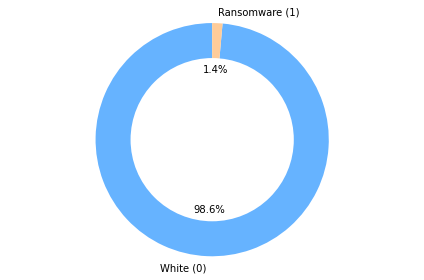

<Figure size 1440x1440 with 0 Axes>

In [20]:
print('\t Distribution of target variable with Imbalance data ')
labels = ['White (0)', 'Ransomware (1)']
sizes = [pd.Series(data.label).value_counts()[0], pd.Series(data.label).value_counts()[1]]
explode = (0, 0.1)
colors = ['#66b3ff','#ffcc99']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()
plt.figure(figsize=(20,20))
plt.savefig('Distribution of TV with Imbalance data.png', transparent=True, bbox_inches='tight')

# 

#### 4.5 Handling The Class Imbalance Struggle

  1. Find Number of samples which are Ransomware

In [21]:
ransomware = len(data[data['label'] == 1])

2. Get indices of non Ransomware samples

In [22]:
non_ransomware_indices = data[data.label == 0].index

3. Random sample non Ransomware indices

In [23]:
random_indices = np.random.choice(non_ransomware_indices,ransomware, replace=False)

4. Find the indices of Ransomware samples

In [24]:
ransomware_indices = data[data.label == 1].index

5. Concat fraud indices with sample non-Ransomware ones

In [25]:
under_sample_indices = np.concatenate([ransomware_indices,random_indices])

6. Get Balance Dataframe

In [26]:
under_sample = data.loc[under_sample_indices]

In [27]:
under_sample.label.value_counts()

0    41413
1    41413
Name: label, dtype: int64

# 

- #### Labels visualization after handling the  Imbalance struggle

	 Distribution of Target Variable with Balanced data


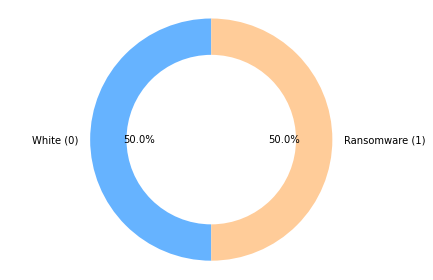

<Figure size 1440x1440 with 0 Axes>

In [28]:
print('\t Distribution of Target Variable with Balanced data')
labels = ['White (0)', 'Ransomware (1)']
sizes = [pd.Series(under_sample.label).value_counts()[0], pd.Series(under_sample.label).value_counts()[1]]
explode = (0, 0.1)
colors = ['#66b3ff','#ffcc99']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

plt.figure(figsize=(20,20))
plt.savefig('Distribution of TV with Balanced data.png', transparent=True, bbox_inches='tight')

# 

#### 4.6 Feature  Distribution 

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

(30000000.0, 9791957416676.0)

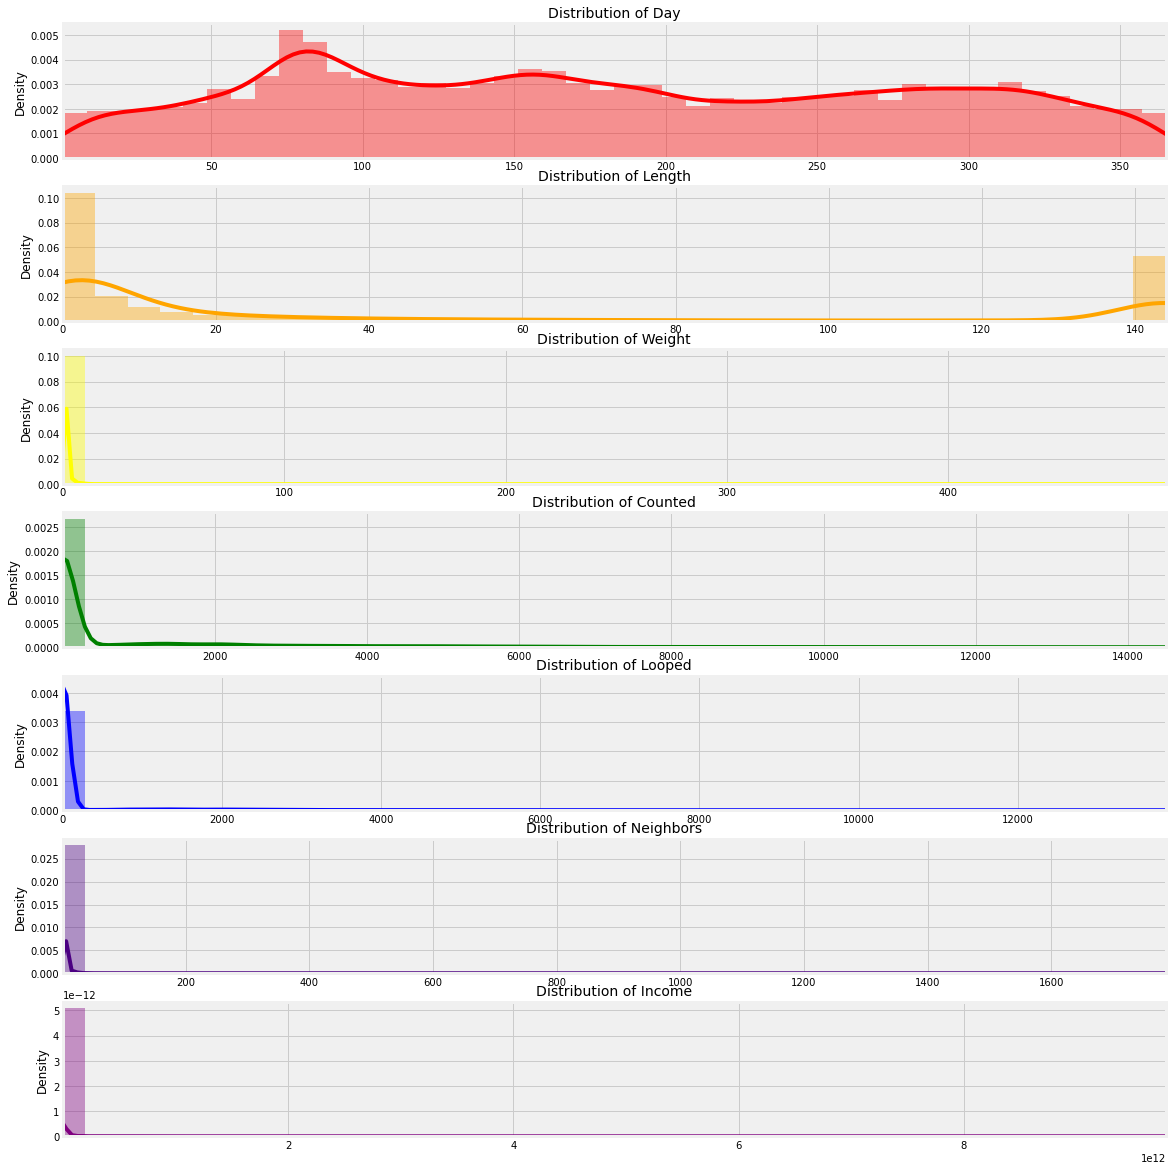

In [29]:
# distplot to show how the data is distributed.

fig, ax = plt.subplots(7, 1,figsize=(16,16))
fig.tight_layout()

day_val       = under_sample.day.values
length_val    = under_sample.length.values
weight_val    = under_sample.weight.values
counted_val   = under_sample.counted.values
looped_val    = under_sample.looped.values
neighbors_val = under_sample.neighbors.values
income_val    = under_sample.income.values

sns.distplot(day_val, ax=ax[0],color='red')
ax[0].set_title('Distribution of Day', fontsize=14)
ax[0].set_xlim([min(day_val), max(day_val)])

sns.distplot(length_val, ax=ax[1],color='orange')
ax[1].set_title('Distribution of Length', fontsize=14)
ax[1].set_xlim([min(length_val), max(length_val)])

sns.distplot(weight_val, ax=ax[2],color='yellow')
ax[2].set_title('Distribution of Weight', fontsize=14)
ax[2].set_xlim([min(weight_val), max(weight_val)])

sns.distplot(counted_val, ax=ax[3],color='green')
ax[3].set_title('Distribution of Counted', fontsize=14)
ax[3].set_xlim([min(counted_val), max(counted_val)])

sns.distplot(looped_val, ax=ax[4],color='blue')
ax[4].set_title('Distribution of Looped', fontsize=14)
ax[4].set_xlim([min(looped_val), max(looped_val)])

sns.distplot(neighbors_val, ax=ax[5],color='indigo')
ax[5].set_title('Distribution of Neighbors', fontsize=14)
ax[5].set_xlim([min(neighbors_val), max(neighbors_val)])

sns.distplot(income_val, ax=ax[6],color='purple')
ax[6].set_title('Distribution of Income', fontsize=14)
ax[6].set_xlim([min(income_val), max(income_val)])

- Since the data is not in normal distribution, we will perform the Box-Cox transformation to transforms our data so that it closely resembles a normal distribution.
you will see later how the Box-Cox you change the distribution.

# 

### 5.  Baseline 

- Data Spliting ( Features and Target ) 

In [30]:
X = under_sample.drop('label',axis=1)
y = under_sample.label

to_be_dropped = ['address']
X = X.drop(to_be_dropped, axis=1, errors='ignore')

- Data Scaling 

In [31]:
std_scale = StandardScaler()
X_sc = std_scale.fit_transform(X) 

- Data Spliting (Train and Test)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y,test_size = 0.2, random_state=42)

- Build The Model

In [33]:
logit = LogisticRegression(C = 1000) # c=comblictiy , to deal with regularaization.
logit.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))

The score for logistic regression is
Training:  62.10%
Test set:  62.38%


- Confusion Matrix

In [36]:
print("confusion matrix: \n\n", confusion_matrix(y_test, logit.predict(X_test)))

confusion matrix: 

 [[4352 3935]
 [2297 5982]]


- Prediction Scores

In [45]:
y_predict = logit.predict(X_test)

print("Default threshold:")
print("Precision:{:6.4f} , Recall:{:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision:0.6032 , Recall:0.7226


In [48]:
print("F score:", f1_score(y_test,y_predict))

F score: 0.6575071444273467


# 

### 6. Feature engineering

Extract features from raw data via data mining techniques,  
these features can be used to improve the performance of machine learning algorithms.

 #### 1. n_address_feature

- The feature contains the number of times the address has been seen in the data set  
(boxcox transformation applied)

In [49]:
under_sample['address'].value_counts()

1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU    420
16cVG72goMe4sNqZhnpmnqfCMZ1uSFbUit    261
12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza    207
12YursV58dRT2c9iuZg3jEWfwgTDamBcnd    183
1LEq4WmpCrqBd7V3PywE2nvFUFC3QTe52x    176
                                     ... 
1PzWEv1FNLoG9dbn2r7iPWAUk2r39WS9AU      1
1KhTzbS8HR5cGqzWbbKB6CEn2NRxPmsddD      1
1AA7fUi58hAKrEV9s9KAwA6EceWeTiq9XS      1
1FGpy6kjRMJJtA1ntCjBe5xvmoKqizyeXS      1
1E9wBrMgbSrx13Z71oy4p1uhSCi2b2rFw5      1
Name: address, Length: 61987, dtype: int64

In [50]:
n_addresses = list(under_sample['address'].value_counts())

In [51]:
print('An address is repeated an average of {} number of times'.format(np.mean(n_addresses)))

An address is repeated an average of 1.3361833932921419 number of times


/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


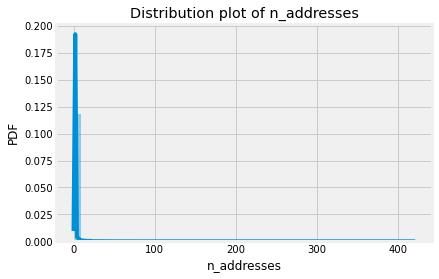

In [52]:
#plot to print distribution of n_addresses

plt.title('Distribution plot of n_addresses')
sns.distplot(n_addresses)
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

In [53]:
dict_n_address = dict(under_sample['address'].value_counts())
#dict_n_address contains a dictionary of addresses and the number of times they appear in data set

n_address = boxcox(np.array(list(dict_n_address.values())))[0]
#Applying boxcox over all the number of times each address apears

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


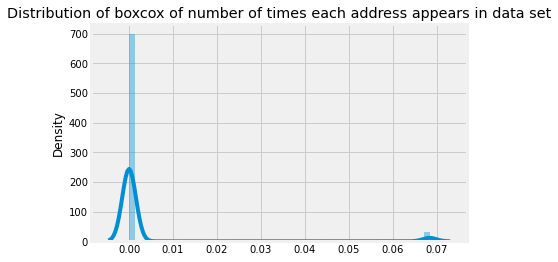

In [54]:
sns.distplot(n_address)
plt.title('Distribution of boxcox of number of times each address appears in data set')
plt.show()

In [55]:
len(n_address) == len(np.array(list(dict_n_address.values()))) #just a sanity check

True

In [56]:
for index, key in tqdm(enumerate(dict_n_address.keys())):
    #We are updating the dictionary with number of times each address appears with
    #the boxcox transformation applied to fix the skewness
    updated = {key: n_address[index]}
    dict_n_address.update(updated)

0it [00:00, ?it/s]

In [57]:
pd.Series(list(dict_n_address.values())).value_counts()

0.000000    59195
0.068376     1012
0.068379      442
0.068379      429
0.068379      219
0.068379      188
0.068379      149
0.068379      107
0.068379       73
0.068379       54
0.068379       48
0.068379       37
0.068379       34
dtype: int64

In [58]:
n_address_feature = np.array([])

for index, row in tqdm(under_sample.iterrows(), total=under_sample.shape[0]):
    #We are getting a list of the new values
    #For each address in the data set we are appending its corresponding boxcox'd
    #number of times its appeared in data set

    n_address_i = dict_n_address.get(under_sample.loc[index]['address']) 
    n_address_feature= np.append(n_address_feature, n_address_i)

  0%|          | 0/82826 [00:00<?, ?it/s]

# 

#### 2. quarter_number

- Feature indicates which quarter of the year the day number belongs to.

In [59]:
def get_quarter(day):
    if day <= 91:
        #First 3 months, so we return quarter number = 1
        return 1
    elif day <= 91 * 2:
        #Next 3 months, quarter number = 2
        return 2
    elif day <= 91 * 3:
        #Next 3 months, quarter number = 3
        return 3
    else:
        #Last 4 months, quarter nubmer = 4
        return 4

In [60]:
quarter_number_feature = np.array([])
day_train = under_sample['day']

for day in tqdm(day_train):
    #For each day, we append its correspoding quarter number

    quarter_number_feature = np.append(quarter_number_feature, get_quarter(day))

  0%|          | 0/82826 [00:00<?, ?it/s]

# 

#### 3. is_close_to_holiday

- Feature indicates if the day number was close to a major public holiday in America.

In [61]:
public_holidays = [
    1, #New Year’s Day, January 1
    15, #Birthday of Martin Luther King, Jr, 15 January
    53, #Washington's birthday February 22
    151, #Memorial day, May 31
    185, #Independence day, July 4
    121, #Labor day, May 1
    285, #Columbus day, October 12
    315, #Veteran's day, November 11
    330, #Thanksgiving day, November 26
    360, #Christmas day, December 25
]

In [62]:
def is_close(holiday, day):
    #if the day is within 1 week leading upto the holiday or after the holiday return True
    if np.abs(holiday - day) > 7:
        return 0
    return 1

In [63]:
is_close_to_holiday = np.array([], dtype=int)
for index, day in tqdm(enumerate(under_sample['day'])):
    #For each day, we check if its close to any major holiday; if so, we append 1 else 0

    is_close_to_holiday = np.append(is_close_to_holiday, any([is_close(holiday, day) for holiday in public_holidays]))

0it [00:00, ?it/s]

# 

#### 4. day_of_the_week

- Feature indicates the number of the weekday (for eg: 0 for Monday and 6 for Sunday)   
The hypothesis is that the day of the week might correlate with the nature of the transaction.

In [64]:
def get_day_number(first_day, day_i):
    #return day number (0 for monday, 6 for sunday) for day_i
    return (first_day + day_i - 1) % 7

In [65]:
day_of_week = np.array([])
for index, row in tqdm(under_sample.iterrows()):
    #For each data-point, we consider its year and day and calculate what day of the week (Monday, Tuesday, etc)
    #it was when the transaction happened
    
    #datetime.datetime(year, 1, 1).weekday() returns the first day of the year in the year = year
    #using this information, we can calculate the present day

    year_i, day_i = row['year'], row['day']
    day_of_week = np.append(day_of_week, get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

0it [00:00, ?it/s]

# 

#### 5. gaussian_length

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

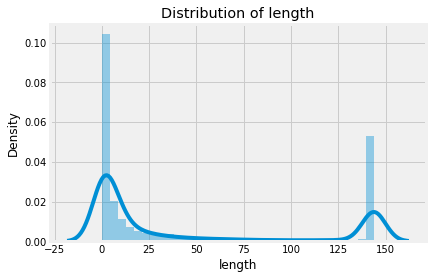

In [66]:
# Looking at its distribution

sns.distplot(under_sample['length'])
plt.title('Distribution of length')
plt.plot()

- Feature tries to fix the skewness of the length variable.   
This is done by applying complex functions over the length feature and then performing a boxcox operation on it.

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


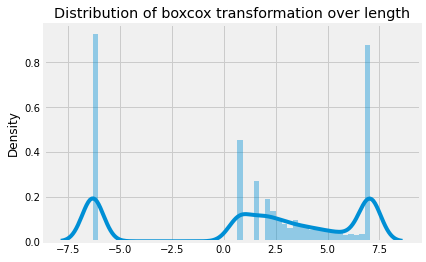

In [67]:
# applying box-cox transformation

sns.distplot(boxcox(np.array(under_sample['length']) + 1e-6)[0])
plt.title('Distribution of boxcox transformation over length')
plt.show()

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


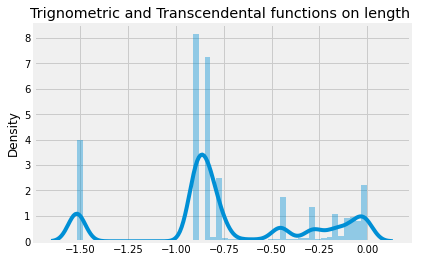

In [68]:
#We can see a sort of 'cyclic' waveform in the above graph. it appears that we have an
#alternating pattern of high and low values. maybe sin transform might help?

sns.distplot(boxcox((np.sin(np.log(np.sqrt(np.array(under_sample['length']) + 1e-6)))) ** 2)[0])
plt.title('Trignometric and Transcendental functions on length ')
plt.show()

- These transformations make the distribution more gaussian and thus, will help during modelling.

In [69]:
gaussian_length = boxcox((np.sin(np.log(np.sqrt(np.array(under_sample['length']) + 1e-6)))) ** 2)[0]

# 

#### 6. gaussian_weight

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


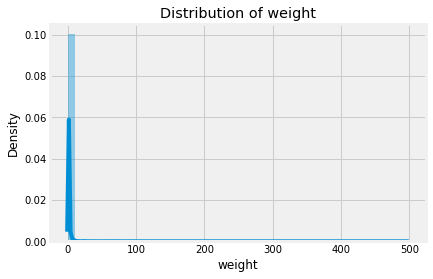

In [70]:
# Looking at its distribution

sns.distplot(under_sample['weight'])
plt.title('Distribution of weight')
plt.show()

- Feature corrects for the skewedness in weight.

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


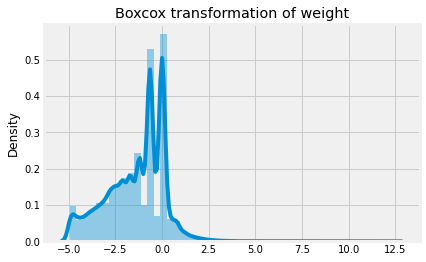

In [71]:
sns.distplot(boxcox(np.array(under_sample['weight'], dtype= float))[0])
plt.title('Boxcox transformation of weight')
plt.show()

In [72]:
#Apply boxcox transform on weight
gaussian_weight = np.array(boxcox(np.array(under_sample['weight'],  dtype=float))[0])

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


# 

#### 7. log_counted

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


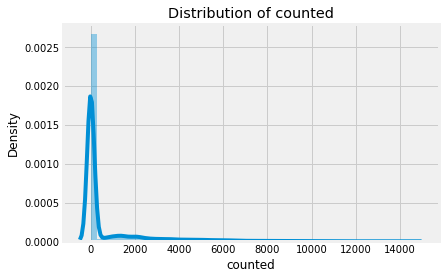

In [73]:
# Looking at its distribution

sns.distplot(under_sample['counted'])
plt.title('Distribution of counted')
plt.show()

- Performing log-transformation to fix skewedness.

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


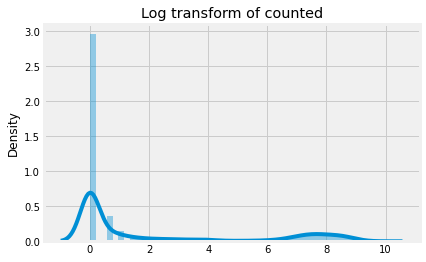

In [74]:
sns.distplot(np.log(np.array(under_sample['counted']) + 1e-6))
plt.title('Log transform of counted')
plt.show()

While performing log to get a normal-distribution still gives us a skewed distribution, 
it is certainly better than the vanilla feature.

In [75]:
#apply log-transform on counted column

log_count = np.log(np.array(under_sample['counted']) + 1e-6)

# 

#### 8. sigmoid_looped

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


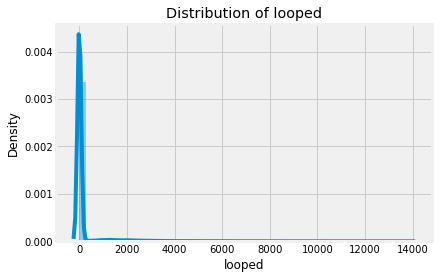

In [76]:
# Looking at its distribution

sns.distplot(under_sample['looped'])
plt.title('Distribution of looped')
plt.show()

- Performing sigmoid operation to fix skewedness.

In [77]:
def sigmoid(x):
    #returns the logistic function of x
    
    return 1 / (1 + np.exp(-x))

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


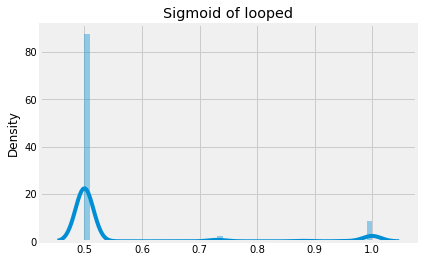

In [78]:
sns.distplot(sigmoid(np.array(under_sample['looped'])))
plt.title('Sigmoid of looped')
plt.show()

- Sigmoidal transformation gives the models a better distribution to work with.

In [79]:
#Applying logistic function on each element of looped

sigmoid_looped = sigmoid(np.array(under_sample['looped']))

# 

#### 9. gaussian_neighbors

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


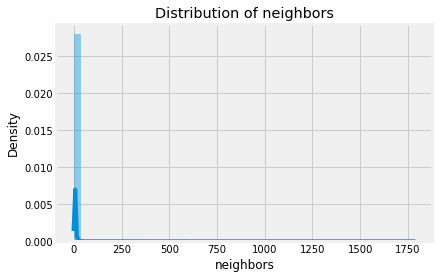

In [80]:
# Looking at its distribution

sns.distplot(under_sample['neighbors'])
plt.title('Distribution of neighbors')
plt.show()

- Feature tries to account for the extreme skewedness of neighbors by applying boxcox transformation.

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


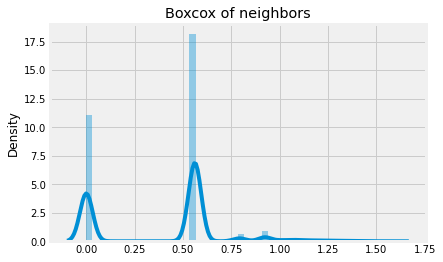

In [81]:
sns.distplot(boxcox(np.array(under_sample['neighbors']) + 1e-6)[0])
plt.title('Boxcox of neighbors')
plt.show()

- Boxcox transformation over Neighbors gives us a slighly more gaussian distribution.

In [82]:
#Applying boxcox transform for neighbors

gaussian_neighbors = boxcox(np.array(under_sample['neighbors']) + 1e-6)[0]

# 

#### 10. gaussian_income

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


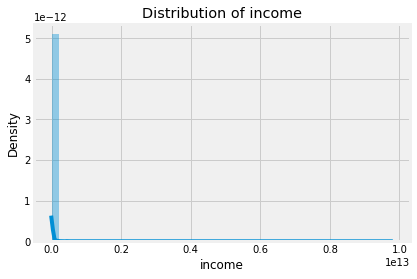

In [83]:
# Looking at its distribution

sns.distplot(under_sample['income'])
plt.title('Distribution of income')
plt.show()

- Feature tries to account for the extreme skewedness of income by applying boxcox transformation.

/Users/macbookproretina13inch/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


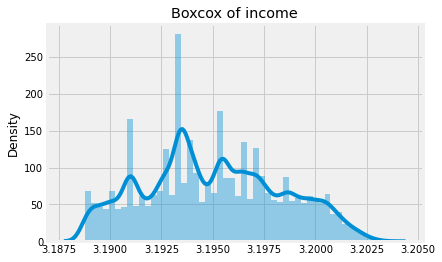

In [84]:
sns.distplot(boxcox(np.array(under_sample['income']) + 1e-6)[0])
plt.title('Boxcox of income')
plt.show()

- Boxcox transformation over Income gives us a psuedo-gaussian distribution.

In [85]:
#Applying boxcox on income

gaussian_income = boxcox(np.array(under_sample['income']) + 1e-6)[0]

# 

### Interaction features

#### 11. Interaction_length_weight

In [86]:
# Between length and weight

median_length = np.median(under_sample['length'])
median_weight = np.median(under_sample['weight'])

def get_length_weight(length_i, weight_i):
    #If length and weight are greater than the median, we will return 0
    #If just length is greater than the median we return 1
    #return 2 if length is lesser than median
    
    if length_i > median_length:
        if weight_i > median_weight:
            return 0
        else:
            return 1
    return 2

In [87]:
#Constructing the interaction feature for train

interaction_length_weight = np.array([])
for index, row in tqdm(under_sample.iterrows(), total=under_sample.shape[0]):
    interaction_length_weight = np.append(interaction_length_weight, get_length_weight(row['length'], row['weight']))

  0%|          | 0/82826 [00:00<?, ?it/s]

# 

#### 12. Interaction_count_income 

In [88]:
# Between log-count and gaussian-income

median_count = np.median(log_count)
median_income = np.median(gaussian_income)

def get_count_income(log_count_i, gaussian_income_i):
    #Return 0 if both log_count and gaussian_income are greater than their medians
    #return 1 if just log_count is
    #return 2 if log count is lesser than median
    
    if log_count_i > median_count:
        if gaussian_income_i > median_income:
            return 0
        else:
            return 1
    return 2

In [89]:
#construct the interaction feature
    
interaction_count_income = np.array([])
for i in tqdm(range(len(log_count))):
    interaction_count_income = np.append(interaction_count_income, get_count_income(log_count[i], gaussian_income[i]))

  0%|          | 0/82826 [00:00<?, ?it/s]

# 

- Loading all the features into the dataset

In [90]:

#Adding the features

under_sample['n_address'] = n_address_feature #1
under_sample['day_of_week'] = day_of_week#2
under_sample['is_close_to_holiday'] = is_close_to_holiday #3
under_sample['quarter_number'] = quarter_number_feature #4
under_sample['gaussian_income'] = gaussian_income #5
under_sample['gaussian_neighbors'] = gaussian_neighbors #6
under_sample['gaussian_weight'] = gaussian_weight#7
under_sample['gaussian_length'] = gaussian_length #8
under_sample['log_count'] = log_count #9
under_sample['sigmoid_looped'] = sigmoid_looped#10
under_sample['interaction_count_income'] = interaction_count_income #11
under_sample['interaction_length_weight'] = interaction_length_weight#12

In [91]:
under_sample.head(2)

,address,year,day,length,weight,counted,looped,neighbors,income,label,...,is_close_to_holiday,quarter_number,gaussian_income,gaussian_neighbors,gaussian_weight,gaussian_length,log_count,sigmoid_looped,interaction_count_income,interaction_length_weight
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,1,...,1,1.0,3.193440,5.612801e-01,-3.068382,-0.015776,9.999995e-07,0.5,2.0,1.0
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,1,...,0,2.0,3.193438,9.999992e-07,-4.028097,-0.103164,9.999995e-07,0.5,2.0,1.0


# 

#### 7.  Strore the Dataset 

In [92]:
# As CSV 
under_sample.to_csv('under_sample_Data.csv', index=False)

# 

- End of this notbook -